In [58]:
import os           
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.sparse import csr_matrix # Разреженые матрицы
from sklearn.feature_extraction.text import CountVectorizer # для мешка слов
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix 
from keras.utils import to_categorical
import keras
from keras import layers
from keras.models import Sequential
import tensorflow as tf
from sklearn.externals import joblib
from tqdm import tqdm

## Константы

In [2]:
PATH_DATA='data/aclImdb'
PATH_TRAIN =os.path.join(PATH_DATA,'train')
PATH_TEST=os.path.join(PATH_DATA,'test')
RANDOM_STATE=64


## Функции

In [3]:
def data_loader( patr_n):
    df=pd.DataFrame(columns=('name','Text','Rat','pos'))
    p=('neg','pos')
    
    for pn in tqdm(p):
        dir_adr=os.path.join(patr_n,pn)
        files=os.listdir(dir_adr)

        for fl in files:
            ls=[]           
            t=fl[:-len('.txt')].split('_')           
            f=open(os.path.join(dir_adr,fl), encoding='utf-8')
            ls.append(t[0])

            ls.append(*f)
            ls.append(t[1])
            ls.append(pn=='pos')
            df.loc[df.shape[0]]=ls
            f.close()
            
    df=df.sort_values('name').reindex(range(df.shape[0]),axis=0)
    
    return df.drop('name',axis=1)



In [4]:
def rat_split(df):
    df=pd.merge(df,pd.get_dummies(df),right_index=True, left_index=True)
    for i in range(1,11):
        i_str=str(i)
        if (i_str in df.columns)==False:
            df[i_str]=0
    return df.drop('Rat',axis=1)[['1','2','3','4','5','6','7','8','9','10']]

In [5]:
def redistribution(d_train,d_test):
    X_train=d_train['Text']
    X_test=d_test['Text']

    y_pos_train=list(d_train['pos'])
    y_pos_test=list(d_test['pos'])

    y_rat_train=rat_split(d_train['Rat'])
    y_rat_test=rat_split(d_test['Rat'])
    
    y_rat_train['5']=0
    y_rat_test['5']=0
    y_rat_train=y_rat_train
    y_rat_test=y_rat_test
    return X_train,X_test, y_pos_train,y_pos_test,y_rat_train,y_rat_test

In [51]:
def confusion_matrix(y_t,y_p):
    expected_outputs = np.argmax(np.array(y_t), axis=1)
    predicted_outputs= np.argmax(y_p, axis=1)
    predicted_confusion_matrix = confusion_matrix(expected_outputs, predicted_outputs)
    return predicted_confusion_matrix
    
    

## Загрузка и оценка данных

In [7]:


%%time
data_train=data_loader(PATH_TRAIN)

data_test=data_loader(PATH_TEST)

100%|██████████| 2/2 [01:47<00:00, 53.99s/it]


Wall time: 3min 37s


In [8]:

data_train.describe()

,Text,Rat,pos
count,25000,25000,25000
unique,24904,8,2
top,You do realize that you've been watching the E...,1,True
freq,3,5100,12500


In [9]:
 data_test.describe()

,Text,Rat,pos
count,25000,25000,25000
unique,24801,8,2
top,Loved today's show!!! It was a variety and not...,1,True
freq,5,5022,12500


In [10]:
data_train.groupby('Rat').size()

Rat
1     5100
10    4732
2     2284
3     2420
4     2696
7     2496
8     3009
9     2263
dtype: int64

In [11]:
data_test.groupby('Rat').size()

Rat
1     5022
10    4999
2     2302
3     2541
4     2635
7     2307
8     2850
9     2344
dtype: int64

In [12]:


X_train,X_test, y_pos_train,y_pos_test,y_rat_train,y_rat_test=redistribution(data_train,data_test)


In [13]:
y_r_train=data_train['Rat']
y_r_test=data_test['Rat']

In [14]:
np.bincount( y_pos_train) ,np.bincount( y_pos_test)

(array([12500, 12500], dtype=int64), array([12500, 12500], dtype=int64))

#### Преобразование текстовых данных

In [28]:
%%time
cv=CountVectorizer()
X_train_sparse=cv.fit_transform(X_train)

Wall time: 4.09 s


In [29]:
len(cv.vocabulary_)

74849

In [30]:
%%time
X_test_sparce=cv.transform(X_test)

Wall time: 3.71 s


#### Преобразование текстовых данных c учетом 2-грамм

In [31]:
%%time
cv2=CountVectorizer(ngram_range=(1,2))
X_train_sparse2=cv2.fit_transform(X_train)


Wall time: 14.1 s


In [32]:
%%time
X_test_sparse2=cv2.transform(X_test)

Wall time: 8.65 s


In [33]:
len(cv2.vocabulary_)

1513832

### Разделение на обучающую и тестовую выборку с другим соотношением

In [34]:
data_all=pd.concat((data_train,data_test),ignore_index=True,sort=False)


In [35]:
ntests=0.3
nTr=(1-ntests)*data_all.shape[0]

from sklearn.model_selection import train_test_split

data_all_train, data_all_test = train_test_split(data_all, test_size=ntests)
X_train_n,X_test_n, y_pos_train_n,y_pos_test_n,y_rat_train_n,y_rat_test_n=redistribution(data_all_train, data_all_test)


In [36]:
%%time
cv_n=CountVectorizer()
X_train_n_sparse=cv_n.fit_transform(X_train_n)

Wall time: 5.64 s


In [37]:
len(cv_n.vocabulary_)

87870

In [38]:
%%time

X_test_n_sparse=cv_n.transform(X_test_n)

Wall time: 2.36 s


In [39]:
X_test_n_sparse.shape

(15000, 87870)

# Модели

## Модели для определения толерантности

#### Обучение моделей логистической регрессии и логистической регрессией со стохастическим градиентным спуском для определения настроения отзыва



In [27]:
logit=LogisticRegression(random_state=64,n_jobs=-1,solver='lbfgs')
sgd_logit=SGDClassifier(max_iter=50,random_state=64,n_jobs=-1)

In [28]:
%%time
logit.fit(X_train_sparse,y_pos_train)

Wall time: 3.4 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=64,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [31]:
%%time
sgd_logit.fit(X_train_sparse,y_pos_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Wall time: 480 ms


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=64, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [32]:
print('logit train:',accuracy_score(y_pos_train,logit.predict(X_train_sparse)),'|logit test:',accuracy_score(y_pos_test,logit.predict(X_test_sparce)))

logit train: 0.98164 |logit test: 0.86384


In [33]:
print('sgd_logit train:', accuracy_score(y_pos_train,sgd_logit.predict(X_train_sparse)),'|sgd_logit test:',accuracy_score(y_pos_test,sgd_logit.predict(X_test_sparce)))

sgd_logit train: 0.99468 |sgd_logit test: 0.8578


#### Обучение моделей логистической регрессии и логистической регрессией с градиентным спуском с би-граммами


In [34]:
logit2=LogisticRegression(random_state=64,n_jobs=-1,solver='lbfgs')
sgd_logit2=SGDClassifier(max_iter=50,random_state=64,n_jobs=-1)

In [35]:
%%time
logit2.fit(X_train_sparse2,y_pos_train)

Wall time: 27 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=64,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [36]:
%%time
sgd_logit2.fit(X_train_sparse2,y_pos_train)

Wall time: 1.11 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=64, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [37]:
print('logit2 train:',accuracy_score(y_pos_train,logit2.predict(X_train_sparse2)),'|logit2 test:',accuracy_score(y_pos_test,logit2.predict(X_test_sparse2)))

logit2 train: 0.99996 |logit2 test: 0.8964


In [38]:
print('sgd_logit2 train:', accuracy_score(y_pos_train,sgd_logit2.predict(X_train_sparse2)),'|sgd_logit2 test:',accuracy_score(y_pos_test,sgd_logit2.predict(X_test_sparse2)))

sgd_logit2 train: 1.0 |sgd_logit2 test: 0.8882


#### метод опорных векторов

In [39]:
svm_l=SVC(kernel='linear',C=100,gamma=0.001,random_state=64, decision_function_shape = 'ovr')

In [40]:
%%time
svm_l.fit(X_train_sparse,y_pos_train)

Wall time: 36min 49s


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=64, shrinking=True, tol=0.001,
    verbose=False)

In [41]:
%%time
y_svm=svm_l.predict(X_test_sparce)

Wall time: 3min 7s


In [42]:
accuracy_score(y_pos_test,y_svm)

0.84236

#### Метод ближайших соседей

In [44]:
knn = KNeighborsClassifier(n_neighbors=15, p=2, metric='minkowski')
knn.fit(X_train_sparse, y_pos_train)

y_pred_knn = knn.predict(X_test_sparce)

In [45]:
accuracy_score(y_pos_test,y_pred_knn)

0.64596

#### Дерево решений

In [48]:
tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=4, 
                              random_state=64)
tree.fit(X_train_sparse, y_pos_train)
y_pred_tree=tree.predict(X_test_sparce)

In [49]:
accuracy_score(y_pos_test,y_pred_tree)

0.67916

## Модели классификации

In [50]:
%%time
logisticClass=LogisticRegression(random_state=64, C=100)
logisticClass.fit(X_train_sparse,y_r_train)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Wall time: 2min 14s


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=64, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
%%time

y_pred_le=logisticClass.predict(X_test_sparce)

Wall time: 41.9 ms


In [54]:
accuracy_score(y_r_test,y_pred_le)



0.33748

In [55]:
%%time
logisticClass2=LogisticRegression(random_state=64, C=100)
logisticClass2.fit(X_train_sparse2,y_r_train)

Wall time: 4min 27s


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=64, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
y_pred_le2=logisticClass2.predict(X_test_sparse2)

In [71]:
accuracy_score(y_r_test,y_pred_le2)

0.40472

In [65]:
svm=SVC(kernel='linear',C=100000,gamma=0.001,random_state=64)

In [66]:

svm.fit(X_train_sparse,y_r_train)

SVC(C=100000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=64, shrinking=True, tol=0.001,
    verbose=False)

In [67]:
%%time
ysvg_pred=svm.predict(X_test_sparce)

Wall time: 9min 58s


In [68]:
accuracy_score(y_r_test,ysvg_pred)

0.36108

In [69]:
tree_r = DecisionTreeClassifier(criterion='gini', 
                              max_depth=4, 
                              random_state=64)
tree_r.fit(X_train_sparse, y_rat_train)
y_pred_tree_r=tree_r.predict(X_test_sparce)

In [70]:
accuracy_score(y_rat_test,y_pred_tree_r)

0.05248

# Сеть

In [42]:
def set_model(X_tr,y_tr,X_val,y_val,ln=1):
    model = Sequential()
    
    # Input - Layer
    model.add(layers.Dense(50, activation = "relu", input_shape=(X_tr.shape[1],)))
    
    # Hidden - Layers

    model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
    model.add(layers.Dense(50, activation = "relu"))
    model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
    model.add(layers.Dense(50, activation = "relu"))
        # Output- Layer
    if(ln==1):
        model.add(layers.Dense(ln, activation = "sigmoid"))
    else:
        model.add(layers.Dense(ln, activation = "softmax"))
    model.summary()
  
    loss="binary_crossentropy" if ln==1 else "categorical_crossentropy"
    optimizer = "adam" if ln==1 else "sgd"
    epoh=800 if ln==1 else 600
    epochs=2 if ln==1 else 45
    metrics=["accuracy"] 
    model.compile(
     optimizer = optimizer,
     loss = loss,
     metrics = metrics
    )
    results = model.fit(
     X_tr, y_tr,
     epochs= epochs,
     batch_size = epoh,
     validation_data = (X_val, y_val)
    )
    
    print("Test-Accuracy:", np.mean(results.history["val_accuracy"]))
    return model


### Определение настроения отзыва

In [99]:
model_pos=set_model(X_train_n_sparse,y_pos_train_n,X_test_n_sparse,y_pos_test_n)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                4412950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 4,418,101
Trainable params: 4,418,101
Non-trainable params: 0
____________________________________________

In [100]:
y_pred_m=model_pos.predict(X_test_n_sparse)

### Определение рейтинга

In [43]:
%%time
model_rat=set_model(X_train_n_sparse,y_rat_train_n,X_test_n_sparse,y_rat_test_n,y_rat_train_n.shape[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                4393550   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
Total params: 4,399,160
Trainable params: 4,399,160
Non-trainable params: 0
____________________________________________

35000/35000 [==============================] - ETA: 23s - loss: 2.1740 - accuracy: 0.221 - ETA: 23s - loss: 2.1613 - accuracy: 0.235 - ETA: 22s - loss: 2.1598 - accuracy: 0.228 - ETA: 22s - loss: 2.1560 - accuracy: 0.221 - ETA: 22s - loss: 2.1540 - accuracy: 0.227 - ETA: 21s - loss: 2.1509 - accuracy: 0.233 - ETA: 21s - loss: 2.1517 - accuracy: 0.232 - ETA: 21s - loss: 2.1524 - accuracy: 0.229 - ETA: 21s - loss: 2.1508 - accuracy: 0.228 - ETA: 21s - loss: 2.1487 - accuracy: 0.233 - ETA: 20s - loss: 2.1486 - accuracy: 0.231 - ETA: 20s - loss: 2.1484 - accuracy: 0.232 - ETA: 19s - loss: 2.1489 - accuracy: 0.233 - ETA: 19s - loss: 2.1493 - accuracy: 0.233 - ETA: 19s - loss: 2.1511 - accuracy: 0.231 - ETA: 18s - loss: 2.1494 - accuracy: 0.233 - ETA: 18s - loss: 2.1505 - accuracy: 0.232 - ETA: 18s - loss: 2.1509 - accuracy: 0.231 - ETA: 17s - loss: 2.1497 - accuracy: 0.232 - ETA: 17s - loss: 2.1487 - accuracy: 0.233 - ETA: 16s - loss: 2.1474 - accuracy: 0.234 - ETA: 16s - loss: 2.1481 - acc

35000/35000 [==============================] - ETA: 22s - loss: 2.0966 - accuracy: 0.223 - ETA: 23s - loss: 2.0615 - accuracy: 0.248 - ETA: 23s - loss: 2.0535 - accuracy: 0.251 - ETA: 23s - loss: 2.0525 - accuracy: 0.256 - ETA: 23s - loss: 2.0511 - accuracy: 0.257 - ETA: 22s - loss: 2.0517 - accuracy: 0.256 - ETA: 22s - loss: 2.0484 - accuracy: 0.260 - ETA: 21s - loss: 2.0476 - accuracy: 0.256 - ETA: 21s - loss: 2.0488 - accuracy: 0.257 - ETA: 21s - loss: 2.0446 - accuracy: 0.261 - ETA: 20s - loss: 2.0439 - accuracy: 0.261 - ETA: 20s - loss: 2.0441 - accuracy: 0.262 - ETA: 19s - loss: 2.0463 - accuracy: 0.261 - ETA: 19s - loss: 2.0472 - accuracy: 0.261 - ETA: 18s - loss: 2.0468 - accuracy: 0.259 - ETA: 18s - loss: 2.0449 - accuracy: 0.261 - ETA: 17s - loss: 2.0433 - accuracy: 0.263 - ETA: 17s - loss: 2.0435 - accuracy: 0.263 - ETA: 17s - loss: 2.0419 - accuracy: 0.265 - ETA: 16s - loss: 2.0409 - accuracy: 0.265 - ETA: 16s - loss: 2.0396 - accuracy: 0.267 - ETA: 15s - loss: 2.0394 - acc

35000/35000 [==============================] - ETA: 22s - loss: 1.9289 - accuracy: 0.315 - ETA: 23s - loss: 1.9335 - accuracy: 0.310 - ETA: 22s - loss: 1.9543 - accuracy: 0.293 - ETA: 22s - loss: 1.9522 - accuracy: 0.293 - ETA: 22s - loss: 1.9610 - accuracy: 0.290 - ETA: 21s - loss: 1.9664 - accuracy: 0.286 - ETA: 21s - loss: 1.9660 - accuracy: 0.288 - ETA: 20s - loss: 1.9639 - accuracy: 0.291 - ETA: 20s - loss: 1.9594 - accuracy: 0.293 - ETA: 20s - loss: 1.9587 - accuracy: 0.293 - ETA: 19s - loss: 1.9592 - accuracy: 0.293 - ETA: 19s - loss: 1.9556 - accuracy: 0.296 - ETA: 18s - loss: 1.9526 - accuracy: 0.299 - ETA: 18s - loss: 1.9546 - accuracy: 0.299 - ETA: 17s - loss: 1.9544 - accuracy: 0.300 - ETA: 17s - loss: 1.9557 - accuracy: 0.298 - ETA: 17s - loss: 1.9560 - accuracy: 0.297 - ETA: 16s - loss: 1.9551 - accuracy: 0.297 - ETA: 16s - loss: 1.9562 - accuracy: 0.297 - ETA: 15s - loss: 1.9522 - accuracy: 0.299 - ETA: 15s - loss: 1.9526 - accuracy: 0.300 - ETA: 14s - loss: 1.9532 - acc

35000/35000 [==============================] - ETA: 21s - loss: 1.8927 - accuracy: 0.341 - ETA: 22s - loss: 1.8861 - accuracy: 0.335 - ETA: 22s - loss: 1.8808 - accuracy: 0.337 - ETA: 21s - loss: 1.8771 - accuracy: 0.336 - ETA: 21s - loss: 1.8698 - accuracy: 0.335 - ETA: 21s - loss: 1.8697 - accuracy: 0.332 - ETA: 20s - loss: 1.8712 - accuracy: 0.332 - ETA: 20s - loss: 1.8762 - accuracy: 0.329 - ETA: 20s - loss: 1.8733 - accuracy: 0.330 - ETA: 19s - loss: 1.8734 - accuracy: 0.330 - ETA: 19s - loss: 1.8746 - accuracy: 0.328 - ETA: 18s - loss: 1.8749 - accuracy: 0.327 - ETA: 18s - loss: 1.8723 - accuracy: 0.330 - ETA: 18s - loss: 1.8709 - accuracy: 0.331 - ETA: 17s - loss: 1.8682 - accuracy: 0.332 - ETA: 17s - loss: 1.8660 - accuracy: 0.333 - ETA: 16s - loss: 1.8666 - accuracy: 0.332 - ETA: 16s - loss: 1.8672 - accuracy: 0.333 - ETA: 16s - loss: 1.8684 - accuracy: 0.333 - ETA: 15s - loss: 1.8674 - accuracy: 0.334 - ETA: 15s - loss: 1.8683 - accuracy: 0.334 - ETA: 14s - loss: 1.8697 - acc

35000/35000 [==============================] - ETA: 21s - loss: 1.7894 - accuracy: 0.363 - ETA: 22s - loss: 1.8071 - accuracy: 0.344 - ETA: 22s - loss: 1.8125 - accuracy: 0.340 - ETA: 21s - loss: 1.8100 - accuracy: 0.340 - ETA: 21s - loss: 1.8190 - accuracy: 0.336 - ETA: 21s - loss: 1.8118 - accuracy: 0.339 - ETA: 20s - loss: 1.8097 - accuracy: 0.339 - ETA: 20s - loss: 1.8143 - accuracy: 0.339 - ETA: 20s - loss: 1.8111 - accuracy: 0.341 - ETA: 19s - loss: 1.8116 - accuracy: 0.340 - ETA: 19s - loss: 1.8100 - accuracy: 0.340 - ETA: 18s - loss: 1.8070 - accuracy: 0.342 - ETA: 18s - loss: 1.8064 - accuracy: 0.342 - ETA: 18s - loss: 1.8109 - accuracy: 0.340 - ETA: 17s - loss: 1.8082 - accuracy: 0.342 - ETA: 17s - loss: 1.8051 - accuracy: 0.345 - ETA: 16s - loss: 1.8046 - accuracy: 0.347 - ETA: 16s - loss: 1.8039 - accuracy: 0.347 - ETA: 16s - loss: 1.8038 - accuracy: 0.345 - ETA: 15s - loss: 1.8022 - accuracy: 0.346 - ETA: 15s - loss: 1.8025 - accuracy: 0.346 - ETA: 14s - loss: 1.8036 - acc

35000/35000 [==============================] - ETA: 22s - loss: 1.7242 - accuracy: 0.373 - ETA: 22s - loss: 1.7274 - accuracy: 0.363 - ETA: 22s - loss: 1.7386 - accuracy: 0.358 - ETA: 22s - loss: 1.7428 - accuracy: 0.359 - ETA: 21s - loss: 1.7485 - accuracy: 0.353 - ETA: 21s - loss: 1.7395 - accuracy: 0.360 - ETA: 21s - loss: 1.7406 - accuracy: 0.361 - ETA: 21s - loss: 1.7361 - accuracy: 0.365 - ETA: 20s - loss: 1.7404 - accuracy: 0.362 - ETA: 20s - loss: 1.7401 - accuracy: 0.362 - ETA: 20s - loss: 1.7406 - accuracy: 0.362 - ETA: 19s - loss: 1.7429 - accuracy: 0.360 - ETA: 19s - loss: 1.7439 - accuracy: 0.359 - ETA: 18s - loss: 1.7440 - accuracy: 0.359 - ETA: 18s - loss: 1.7449 - accuracy: 0.360 - ETA: 17s - loss: 1.7467 - accuracy: 0.359 - ETA: 17s - loss: 1.7448 - accuracy: 0.361 - ETA: 17s - loss: 1.7442 - accuracy: 0.360 - ETA: 16s - loss: 1.7438 - accuracy: 0.360 - ETA: 16s - loss: 1.7451 - accuracy: 0.359 - ETA: 15s - loss: 1.7432 - accuracy: 0.361 - ETA: 15s - loss: 1.7441 - acc

35000/35000 [==============================] - ETA: 23s - loss: 1.6747 - accuracy: 0.378 - ETA: 23s - loss: 1.6880 - accuracy: 0.370 - ETA: 23s - loss: 1.7113 - accuracy: 0.360 - ETA: 23s - loss: 1.7113 - accuracy: 0.364 - ETA: 22s - loss: 1.7141 - accuracy: 0.364 - ETA: 22s - loss: 1.7121 - accuracy: 0.366 - ETA: 22s - loss: 1.7127 - accuracy: 0.367 - ETA: 21s - loss: 1.7130 - accuracy: 0.368 - ETA: 21s - loss: 1.7103 - accuracy: 0.369 - ETA: 20s - loss: 1.7110 - accuracy: 0.367 - ETA: 20s - loss: 1.7060 - accuracy: 0.370 - ETA: 19s - loss: 1.7067 - accuracy: 0.368 - ETA: 19s - loss: 1.7084 - accuracy: 0.365 - ETA: 18s - loss: 1.7077 - accuracy: 0.365 - ETA: 18s - loss: 1.7061 - accuracy: 0.366 - ETA: 18s - loss: 1.7015 - accuracy: 0.368 - ETA: 17s - loss: 1.7004 - accuracy: 0.368 - ETA: 17s - loss: 1.7014 - accuracy: 0.367 - ETA: 16s - loss: 1.6988 - accuracy: 0.369 - ETA: 16s - loss: 1.7004 - accuracy: 0.369 - ETA: 15s - loss: 1.6974 - accuracy: 0.371 - ETA: 15s - loss: 1.6990 - acc

35000/35000 [==============================] - ETA: 22s - loss: 1.7474 - accuracy: 0.368 - ETA: 22s - loss: 1.7195 - accuracy: 0.373 - ETA: 22s - loss: 1.6946 - accuracy: 0.378 - ETA: 21s - loss: 1.6670 - accuracy: 0.387 - ETA: 21s - loss: 1.6659 - accuracy: 0.380 - ETA: 21s - loss: 1.6604 - accuracy: 0.382 - ETA: 20s - loss: 1.6670 - accuracy: 0.381 - ETA: 20s - loss: 1.6713 - accuracy: 0.381 - ETA: 20s - loss: 1.6763 - accuracy: 0.378 - ETA: 19s - loss: 1.6838 - accuracy: 0.374 - ETA: 19s - loss: 1.6810 - accuracy: 0.377 - ETA: 19s - loss: 1.6814 - accuracy: 0.376 - ETA: 18s - loss: 1.6805 - accuracy: 0.377 - ETA: 18s - loss: 1.6802 - accuracy: 0.378 - ETA: 18s - loss: 1.6776 - accuracy: 0.380 - ETA: 17s - loss: 1.6792 - accuracy: 0.378 - ETA: 17s - loss: 1.6782 - accuracy: 0.377 - ETA: 16s - loss: 1.6766 - accuracy: 0.378 - ETA: 16s - loss: 1.6750 - accuracy: 0.377 - ETA: 16s - loss: 1.6717 - accuracy: 0.378 - ETA: 15s - loss: 1.6701 - accuracy: 0.379 - ETA: 15s - loss: 1.6691 - acc

35000/35000 [==============================] - ETA: 22s - loss: 1.6819 - accuracy: 0.366 - ETA: 22s - loss: 1.6497 - accuracy: 0.381 - ETA: 22s - loss: 1.6357 - accuracy: 0.383 - ETA: 22s - loss: 1.6372 - accuracy: 0.390 - ETA: 22s - loss: 1.6395 - accuracy: 0.389 - ETA: 22s - loss: 1.6520 - accuracy: 0.385 - ETA: 21s - loss: 1.6568 - accuracy: 0.384 - ETA: 21s - loss: 1.6582 - accuracy: 0.384 - ETA: 21s - loss: 1.6481 - accuracy: 0.387 - ETA: 21s - loss: 1.6432 - accuracy: 0.390 - ETA: 20s - loss: 1.6430 - accuracy: 0.388 - ETA: 20s - loss: 1.6448 - accuracy: 0.387 - ETA: 19s - loss: 1.6406 - accuracy: 0.387 - ETA: 19s - loss: 1.6404 - accuracy: 0.387 - ETA: 19s - loss: 1.6379 - accuracy: 0.387 - ETA: 18s - loss: 1.6371 - accuracy: 0.388 - ETA: 18s - loss: 1.6370 - accuracy: 0.389 - ETA: 17s - loss: 1.6401 - accuracy: 0.386 - ETA: 17s - loss: 1.6391 - accuracy: 0.387 - ETA: 16s - loss: 1.6386 - accuracy: 0.387 - ETA: 16s - loss: 1.6379 - accuracy: 0.386 - ETA: 15s - loss: 1.6382 - acc

35000/35000 [==============================] - ETA: 23s - loss: 1.6293 - accuracy: 0.381 - ETA: 25s - loss: 1.6055 - accuracy: 0.397 - ETA: 24s - loss: 1.5884 - accuracy: 0.405 - ETA: 24s - loss: 1.5997 - accuracy: 0.405 - ETA: 23s - loss: 1.5931 - accuracy: 0.407 - ETA: 22s - loss: 1.5928 - accuracy: 0.405 - ETA: 22s - loss: 1.5880 - accuracy: 0.406 - ETA: 21s - loss: 1.5861 - accuracy: 0.404 - ETA: 21s - loss: 1.5823 - accuracy: 0.404 - ETA: 20s - loss: 1.5801 - accuracy: 0.406 - ETA: 20s - loss: 1.5790 - accuracy: 0.405 - ETA: 19s - loss: 1.5870 - accuracy: 0.401 - ETA: 19s - loss: 1.6031 - accuracy: 0.396 - ETA: 19s - loss: 1.6182 - accuracy: 0.391 - ETA: 18s - loss: 1.6216 - accuracy: 0.390 - ETA: 18s - loss: 1.6242 - accuracy: 0.387 - ETA: 17s - loss: 1.6209 - accuracy: 0.389 - ETA: 17s - loss: 1.6209 - accuracy: 0.390 - ETA: 16s - loss: 1.6240 - accuracy: 0.388 - ETA: 16s - loss: 1.6218 - accuracy: 0.389 - ETA: 15s - loss: 1.6239 - accuracy: 0.389 - ETA: 15s - loss: 1.6252 - acc

35000/35000 [==============================] - ETA: 23s - loss: 1.5658 - accuracy: 0.425 - ETA: 23s - loss: 1.6327 - accuracy: 0.390 - ETA: 23s - loss: 1.6208 - accuracy: 0.398 - ETA: 22s - loss: 1.6196 - accuracy: 0.395 - ETA: 22s - loss: 1.6198 - accuracy: 0.395 - ETA: 22s - loss: 1.6145 - accuracy: 0.399 - ETA: 21s - loss: 1.6143 - accuracy: 0.400 - ETA: 21s - loss: 1.6085 - accuracy: 0.401 - ETA: 20s - loss: 1.6081 - accuracy: 0.399 - ETA: 20s - loss: 1.6043 - accuracy: 0.400 - ETA: 20s - loss: 1.6017 - accuracy: 0.400 - ETA: 19s - loss: 1.6041 - accuracy: 0.398 - ETA: 19s - loss: 1.6010 - accuracy: 0.400 - ETA: 18s - loss: 1.6031 - accuracy: 0.399 - ETA: 18s - loss: 1.6022 - accuracy: 0.400 - ETA: 17s - loss: 1.6010 - accuracy: 0.400 - ETA: 17s - loss: 1.6001 - accuracy: 0.400 - ETA: 17s - loss: 1.5991 - accuracy: 0.400 - ETA: 16s - loss: 1.5981 - accuracy: 0.400 - ETA: 16s - loss: 1.5973 - accuracy: 0.400 - ETA: 16s - loss: 1.5997 - accuracy: 0.401 - ETA: 15s - loss: 1.6075 - acc

35000/35000 [==============================] - ETA: 23s - loss: 1.5613 - accuracy: 0.401 - ETA: 23s - loss: 1.5318 - accuracy: 0.421 - ETA: 23s - loss: 1.5271 - accuracy: 0.427 - ETA: 23s - loss: 1.5312 - accuracy: 0.424 - ETA: 23s - loss: 1.5424 - accuracy: 0.420 - ETA: 22s - loss: 1.5488 - accuracy: 0.416 - ETA: 22s - loss: 1.5691 - accuracy: 0.408 - ETA: 22s - loss: 1.5711 - accuracy: 0.407 - ETA: 22s - loss: 1.5750 - accuracy: 0.408 - ETA: 21s - loss: 1.5714 - accuracy: 0.410 - ETA: 21s - loss: 1.5679 - accuracy: 0.410 - ETA: 20s - loss: 1.5672 - accuracy: 0.411 - ETA: 20s - loss: 1.5637 - accuracy: 0.412 - ETA: 19s - loss: 1.5656 - accuracy: 0.412 - ETA: 19s - loss: 1.5741 - accuracy: 0.408 - ETA: 18s - loss: 1.5743 - accuracy: 0.409 - ETA: 18s - loss: 1.5717 - accuracy: 0.410 - ETA: 17s - loss: 1.5698 - accuracy: 0.410 - ETA: 17s - loss: 1.5667 - accuracy: 0.411 - ETA: 16s - loss: 1.5665 - accuracy: 0.411 - ETA: 16s - loss: 1.5641 - accuracy: 0.412 - ETA: 15s - loss: 1.5623 - acc

35000/35000 [==============================] - ETA: 23s - loss: 1.4856 - accuracy: 0.440 - ETA: 23s - loss: 1.5238 - accuracy: 0.429 - ETA: 23s - loss: 1.5329 - accuracy: 0.418 - ETA: 23s - loss: 1.5276 - accuracy: 0.412 - ETA: 23s - loss: 1.5163 - accuracy: 0.417 - ETA: 22s - loss: 1.5205 - accuracy: 0.416 - ETA: 22s - loss: 1.5201 - accuracy: 0.416 - ETA: 22s - loss: 1.5185 - accuracy: 0.414 - ETA: 21s - loss: 1.5245 - accuracy: 0.413 - ETA: 21s - loss: 1.5397 - accuracy: 0.409 - ETA: 20s - loss: 1.5475 - accuracy: 0.407 - ETA: 20s - loss: 1.5506 - accuracy: 0.407 - ETA: 19s - loss: 1.5476 - accuracy: 0.408 - ETA: 19s - loss: 1.5451 - accuracy: 0.409 - ETA: 18s - loss: 1.5435 - accuracy: 0.410 - ETA: 18s - loss: 1.5420 - accuracy: 0.410 - ETA: 18s - loss: 1.5376 - accuracy: 0.413 - ETA: 17s - loss: 1.5399 - accuracy: 0.412 - ETA: 17s - loss: 1.5410 - accuracy: 0.410 - ETA: 16s - loss: 1.5472 - accuracy: 0.409 - ETA: 16s - loss: 1.5552 - accuracy: 0.407 - ETA: 15s - loss: 1.5568 - acc

35000/35000 [==============================] - ETA: 22s - loss: 1.6881 - accuracy: 0.366 - ETA: 22s - loss: 1.6435 - accuracy: 0.391 - ETA: 22s - loss: 1.6057 - accuracy: 0.394 - ETA: 22s - loss: 1.5908 - accuracy: 0.397 - ETA: 22s - loss: 1.5754 - accuracy: 0.399 - ETA: 21s - loss: 1.5605 - accuracy: 0.405 - ETA: 21s - loss: 1.5511 - accuracy: 0.407 - ETA: 20s - loss: 1.5413 - accuracy: 0.412 - ETA: 20s - loss: 1.5437 - accuracy: 0.412 - ETA: 20s - loss: 1.5383 - accuracy: 0.416 - ETA: 19s - loss: 1.5344 - accuracy: 0.416 - ETA: 19s - loss: 1.5388 - accuracy: 0.416 - ETA: 18s - loss: 1.5498 - accuracy: 0.410 - ETA: 18s - loss: 1.5549 - accuracy: 0.410 - ETA: 18s - loss: 1.5511 - accuracy: 0.411 - ETA: 17s - loss: 1.5438 - accuracy: 0.414 - ETA: 17s - loss: 1.5417 - accuracy: 0.413 - ETA: 17s - loss: 1.5400 - accuracy: 0.414 - ETA: 16s - loss: 1.5395 - accuracy: 0.416 - ETA: 16s - loss: 1.5376 - accuracy: 0.416 - ETA: 15s - loss: 1.5357 - accuracy: 0.417 - ETA: 15s - loss: 1.5386 - acc

35000/35000 [==============================] - ETA: 26s - loss: 1.5821 - accuracy: 0.401 - ETA: 25s - loss: 1.5750 - accuracy: 0.404 - ETA: 24s - loss: 1.5424 - accuracy: 0.412 - ETA: 23s - loss: 1.5360 - accuracy: 0.407 - ETA: 23s - loss: 1.5356 - accuracy: 0.408 - ETA: 22s - loss: 1.5271 - accuracy: 0.409 - ETA: 22s - loss: 1.5255 - accuracy: 0.414 - ETA: 21s - loss: 1.5335 - accuracy: 0.412 - ETA: 21s - loss: 1.5420 - accuracy: 0.412 - ETA: 21s - loss: 1.5500 - accuracy: 0.409 - ETA: 20s - loss: 1.5496 - accuracy: 0.409 - ETA: 20s - loss: 1.5460 - accuracy: 0.410 - ETA: 19s - loss: 1.5381 - accuracy: 0.412 - ETA: 19s - loss: 1.5391 - accuracy: 0.412 - ETA: 18s - loss: 1.5327 - accuracy: 0.414 - ETA: 18s - loss: 1.5276 - accuracy: 0.415 - ETA: 17s - loss: 1.5269 - accuracy: 0.417 - ETA: 17s - loss: 1.5234 - accuracy: 0.417 - ETA: 16s - loss: 1.5203 - accuracy: 0.418 - ETA: 16s - loss: 1.5200 - accuracy: 0.419 - ETA: 16s - loss: 1.5226 - accuracy: 0.418 - ETA: 15s - loss: 1.5279 - acc

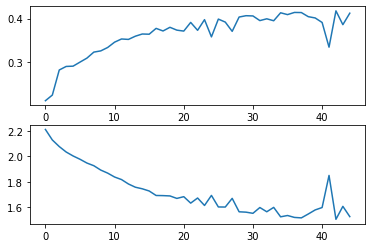

In [59]:

plt.figure()
plt.subplot(211)
plt.plot(model_rat.history.history['val_accuracy'])
plt.subplot(212)
plt.plot(model_rat.history.history['val_loss']);

In [54]:

%%time
y_pred_rat=model_rat.predict(X_test_n_sparse)

Wall time: 9.2 s


In [63]:
def pred_confusion_matrix(y_t,y_p):
    expected_outputs = np.argmax(np.array(y_t), axis=1)
    predicted_outputs= np.argmax(y_p, axis=1)
    predicted_confusion_matrix = confusion_matrix(expected_outputs, predicted_outputs)
    return predicted_confusion_matrix

In [64]:
pred_confusion_matrix(y_rat_test_n,y_pred_rat)

array([[2583,    1,  126,  219,    9,    1,    0,  112],
       [ 898,    1,  133,  271,    7,    2,    0,   62],
       [ 688,    1,  167,  526,   23,    3,    0,   85],
       [ 486,    1,  170,  783,   52,   17,    0,  122],
       [  97,    0,   24,  481,  264,  105,    0,  460],
       [ 109,    0,   17,  320,  257,  146,    0,  922],
       [  81,    0,    6,  163,  118,   77,    0,  926],
       [ 238,    0,   10,  191,  109,   87,    0, 2243]], dtype=int64)

### Сохранение моделей

In [ ]:
joblib.dump(cv_n, 'wordbag.pkl') ### сохранение модели предобработки текста

In [ ]:
joblib.dump(model_pos, 'positivmodel.pkl') ### сохранение модели определения настроения

In [ ]:
joblib.dump(model_rat, 'ratingmodel.pkl') ### ### сохранение модели определения рейтинга